### Import Statements

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
import shutil
import imageio
import scipy
import pandas as pd
from functools import partial
from utils.history_utils import save_history

GPU = 1
use_mixed_prec = False

physical_gpus = tf.config.list_physical_devices('GPU')
if physical_gpus:
    try:
        # Disable GPU
        tf.config.set_visible_devices(physical_gpus[GPU:GPU+1], 'GPU')
        visible_gpus = tf.config.get_visible_devices('GPU')
        print("Num Visible Physical GPUs: ", len(physical_gpus),
              "\nNum Visible GPUs Available: ", len(visible_gpus))
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(visible_gpus), "Visible GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

%matplotlib inline
%load_ext autoreload
%autoreload 2
MAP_AUTOTUNE = int(os.cpu_count()*3/4)#tf.data.AUTOTUNE#os.cpu_count()#int(os.cpu_count()*3/4)
AUTOTUNE = tf.data.AUTOTUNE
print('Tensorflow version: ' + tf.__version__)
os.environ['NO_GCE_CHECK'] = 'true'

# For Mixed Precision
from tensorflow.keras import mixed_precision
if use_mixed_prec:
    mixed_precision.set_global_policy('mixed_float16')

Num Visible Physical GPUs:  2 
Num Visible GPUs Available:  1
1 Visible GPUs, 1 Logical GPUs
Tensorflow version: 2.8.0


## Creating Dataset:

In [2]:
builder = tfds.ImageFolder('./data', shape=(None, None, 3))

In [3]:
print(builder.info)
metadata = builder.info

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='./data',
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=1),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=800, num_shards=1>,
        'val': <SplitInfo num_examples=100, num_shards=1>,
    },
    citation="""""",
)


In [4]:
# tf.data.experimental.save(dataset, path)
# new_dataset = tf.data.experimental.load(path)

## Creating Input Pipeline

In [5]:
from utils.downsampling_utils import downsample, downsample_zerofill, downsample_interp
from utils.augmentation_utils import augment, keras_augment, normalize, augment_noise

In [6]:
(train_ds, val_ds) = builder.as_dataset(split=['train', 'val'], shuffle_files=False)

In [7]:
NUM_TRAIN = tf.data.experimental.cardinality(train_ds).numpy()
NUM_VAL = tf.data.experimental.cardinality(val_ds).numpy()

In [8]:
train_ds = train_ds.map(lambda x: x['image'],
                        num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds = val_ds.map(lambda x: x['image'],
                    num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

In [9]:
norm_range = [0, 1]
norm_func = partial(normalize, clip=False, out_range=norm_range, if_uint8=True)
train_ds = train_ds.map(norm_func,
                        num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds = val_ds.map(norm_func,
                    num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

In [10]:
norm_range = [0, 1]
CROP_SIZE = (256, 256, 3)
INIT_SEED = 7
PROB_OF_AUG = 1/2#1/3 # prob [0,1]
MAX_BRIGHT_SHIFT = 0.1 # in range [0,1]
LOWER_CONTRAST_FACTOR = 0.5#0.75
UPPER_CONTRAST_FACTOR = 1.5#1.25
MAX_HUE_DELTA = 0.05
JPEG_QUALITY_RANGE = [75, 100]
SAT_FACTOR_RANGE = [0.9, 1.1]


GAUSS_NOISE_MEAN = 0
LOWER_GAUSS_NOISE_STD = 0.05
UPPER_GAUSS_NOISE_STD = 0.25

MAX_SHIFT_FRACTION_X_Y = [0.1, 0.1]
MAX_ROTATION_DEG = 10
MAX_ZOOM_FRACTION_X_Y = [0.9, 0.9]
MAX_CHANNEL_INTENSITY_SHIFT = 0.1
SHEAR_INTENSITY = 0.1
FILL_MODE = 'nearest' #'constant'
INTERP_ORD = 3 # No Interp

In [11]:
main_augment = partial(augment, prob=PROB_OF_AUG,
                       max_shift=MAX_BRIGHT_SHIFT,
                       con_factor_range=[LOWER_CONTRAST_FACTOR, 
                                         UPPER_CONTRAST_FACTOR],
                       max_hue_delta=MAX_HUE_DELTA,
                       jpeg_quality_range=JPEG_QUALITY_RANGE,
                       sat_factor_range=SAT_FACTOR_RANGE,
                       out_range=norm_range,
                       seed=INIT_SEED)
secondary_augment = partial(augment_noise, prob=PROB_OF_AUG,
                            mean=GAUSS_NOISE_MEAN,
                            std_lower=LOWER_GAUSS_NOISE_STD,
                            std_upper=UPPER_GAUSS_NOISE_STD,
                            out_range=norm_range,
                            seed=INIT_SEED)

rand_crop = partial(tf.image.random_crop, size=CROP_SIZE)

lambda_map_func = partial(keras_augment, fill_mode=FILL_MODE,
                          interpolation_order=INTERP_ORD,
                          max_shift_xy=MAX_SHIFT_FRACTION_X_Y,
                          rg=MAX_ROTATION_DEG,
                          zoom_range=MAX_ZOOM_FRACTION_X_Y,
                          intensity_range=MAX_CHANNEL_INTENSITY_SHIFT,
                          shear_intensity=SHEAR_INTENSITY,
                          out_range=norm_range)

lambda_func = lambda x: tf.numpy_function(lambda_map_func, [x], tf.float32)

In [12]:
train_ds = (
    train_ds
    .cache()
    .map(rand_crop, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
    .map(main_augment, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
    .map(secondary_augment, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
    .map(lambda_func, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
)
val_ds = (
    val_ds
    .cache()
    .map(rand_crop, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
)

In [13]:
# img = next(iter(test_ds))
# figsize = (7, 7)
# fig = plt.figure(figsize=figsize)
# ax = fig.add_axes([0, 0, 1, 1])
# ax.axis('off')
# ax.imshow(img)
# plt.title('Test Image')
# plt.show()

In [14]:
# img = next(iter(test_ds))
# figsize = (7, 7)
# fig = plt.figure(figsize=figsize)
# ax = fig.add_axes([0, 0, 1, 1])
# ax.axis('off')
# ax.imshow(img)
# plt.title('Test Image')
# plt.show()

## Define Model Input and Ground Truth

In [15]:
# def define_in_out(x):
#     return x, x

In [16]:
from utils.jpeg_utils import jpeg_encode_decode
QUALITY = 20#20#50

def define_in_out(x):
    return jpeg_encode_decode(x, QUALITY), x 
define_in_out_func = lambda x: tf.numpy_function(define_in_out, [x], [tf.float32, tf.float32])

In [17]:
train_ds = (
    train_ds
    .map(define_in_out_func, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
)
val_ds = (
    val_ds
    .map(define_in_out_func, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
)

## Model Training:

In [18]:
# Import Model:
# from models.AutoEncoder import getModel
# from models.AutoEncoder_v2 import getModel
# from models.AutoEncoder_v3 import getModel
# from models.AutoEncoder_v4 import getModel
# from models.AutoEncoder_v5 import getModel
# from models.AutoEncoder_v6 import getModel
# from models.AutoEncoder_v7 import getModel
# from models.AutoEncoder_v8 import getModel
# from models.AutoEncoder_v9 import getModel
# from models.AutoEncoder_v10 import getModel
# from models.AutoEncoder_v11 import getModel
# from models.AutoEncoder_v12 import getModel
# from models.AutoEncoder_v13 import getModel
# from models.AutoEncoder_v14 import getModel
# from models.AutoEncoder_v15 import getModel
# from models.AutoEncoder_v16 import getModel
# from models.AutoEncoder_v17 import getModel
from models.UNet import getModel

In [19]:
# Hyperparameters:
INPUT_SHAPE = [None, None, 3]
KERNEL_SIZE = [11, 11]#[7, 7]
DILATION_RATE = 2
BATCH_SIZE = 16#8
EPOCHS = 200
FILTERS = 16#4#8#32
# DROP_PROB = 0.05#0.075#0.05#0.075#0.25#0.1#0.05
KERNEL_REGULARIZER = tf.keras.regularizers.L2(0.00001)#None#tf.keras.regularizers.L2(0.0001)#None#tf.keras.regularizers.L2(0.0001)
KERNEL_INITIALIZER = "glorot_normal"#"orthogonal"#"glorot_normal"#"orthogonal"
DROP_PROB = None#0#0.15
INITIAL_LR = 0.005#0.001
LR_DECAY = 0.97#0.96#0.98#0.95#0.9#0.97#0.95#0.97#0.93
LR_DECAY_START = 10#25
ACTIVATION = 'elu'
AUGMENTATIONS = 20#10#1#10
VAL_AUGMENTATIONS = 10#1#10#5#10#100
MODEL_DIR = f'saved_models_{GPU}'
BUFFER_SIZE = 800
UPDATE_INFO_EVERY_X_EPOCHS = 25#47#94#310
delete_previous = True
SAVE_METRIC = 'val_loss'

In [20]:
model_kwargs = {'filters': FILTERS,
                'kernel_size': KERNEL_SIZE, 
                'activation': ACTIVATION,
                'dilation_rate': DILATION_RATE,
                'prob': DROP_PROB,
                'kernel_initializer': KERNEL_INITIALIZER,
                'kernel_regularizer': KERNEL_REGULARIZER}

In [21]:
from utils.model_utils import model_loss, PSNR, SSIM

# B1 = 1
# B2 = 0.001
# PIXELWISE_LOSS = tf.keras.losses.MeanAbsoluteError()
# loss_func = model_loss(B1, B2, pixelwise_loss=PIXELWISE_LOSS, name='loss')

loss_func = tf.keras.losses.MeanAbsoluteError()

In [22]:
train_ds = (
    train_ds
    .prefetch(AUTOTUNE)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTOTUNE)
)
val_ds = (
    val_ds
    .prefetch(AUTOTUNE)
    .shuffle(BUFFER_SIZE//4)# was //8
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTOTUNE)
)

In [23]:
def scheduler(epoch, lr):
    if epoch <= LR_DECAY_START:
        return (epoch/LR_DECAY_START)*INITIAL_LR + INITIAL_LR/10000
    elif epoch < 2*LR_DECAY_START:
        return lr
    elif epoch >= 2*LR_DECAY_START:
        return lr*LR_DECAY

In [24]:
model = getModel(input_shape=INPUT_SHAPE, **model_kwargs)

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=INITIAL_LR)#, amsgrad=True)#, clipvalue=10)
if use_mixed_prec:
    optimizer = mixed_precision.LossScaleOptimizer(optimizer)
model.compile(optimizer=optimizer,  # pick an optimizer
              loss=loss_func,
              steps_per_execution=((AUGMENTATIONS) * np.ceil(NUM_TRAIN/BATCH_SIZE)) // UPDATE_INFO_EVERY_X_EPOCHS,
              metrics=['mean_absolute_error', 'mean_squared_error', SSIM, PSNR])

In [26]:
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   5824        ['img[0][0]']                    
                                16)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   64         ['conv2d[0][0]']                 
 alization)                     16)                                                            

In [27]:
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
elif delete_previous:
    shutil.rmtree(MODEL_DIR)
    os.mkdir(MODEL_DIR)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODEL_DIR, 
                                                                            'saved_model-epoch_{epoch:02d}-' + 
                                                                            SAVE_METRIC + '_{' + 
                                                                            SAVE_METRIC + ':.5f}.h5'),
                                                      monitor=SAVE_METRIC,
                                                      verbose=0,
                                                      save_best_only=True,
                                                      save_weights_only=False,
                                                      mode='min',
                                                      save_freq='epoch')

my_callbacks = [model_checkpoint, lr_schedule]

history = model.fit(train_ds,
                    steps_per_epoch=AUGMENTATIONS*np.ceil(NUM_TRAIN/BATCH_SIZE),
                    epochs=EPOCHS,
                    callbacks=my_callbacks,
                    validation_data=val_ds,
                    validation_steps=VAL_AUGMENTATIONS*np.ceil(NUM_VAL/BATCH_SIZE),
                    max_queue_size=10*AUGMENTATIONS*np.ceil(NUM_TRAIN/BATCH_SIZE))

Epoch 1/200
1000/1000 [==============================] - 493s 493ms/step - loss: 0.6469 - mean_absolute_error: 0.6069 - mean_squared_error: 1.0003 - SSIM: 0.0079 - PSNR: 3.0488 - val_loss: 0.4337 - val_mean_absolute_error: 0.3937 - val_mean_squared_error: 1.6158 - val_SSIM: 0.0340 - val_PSNR: 8.0444 - lr: 5.0000e-07
Epoch 2/200
1000/1000 [==============================] - 415s 415ms/step - loss: 0.0845 - mean_absolute_error: 0.0478 - mean_squared_error: 0.9645 - SSIM: 0.7615 - PSNR: 25.2868 - val_loss: 0.0984 - val_mean_absolute_error: 0.0688 - val_mean_squared_error: 20.9505 - val_SSIM: 0.7249 - val_PSNR: 23.2754 - lr: 5.0050e-04
Epoch 3/200
1000/1000 [==============================] - 414s 414ms/step - loss: 0.0554 - mean_absolute_error: 0.0338 - mean_squared_error: 0.9130 - SSIM: 0.8040 - PSNR: 26.7018 - val_loss: 0.0423 - val_mean_absolute_error: 0.0268 - val_mean_squared_error: 0.6434 - val_SSIM: 0.8313 - val_PSNR: 29.1662 - lr: 0.0010
Epoch 4/200
1000/1000 [======================

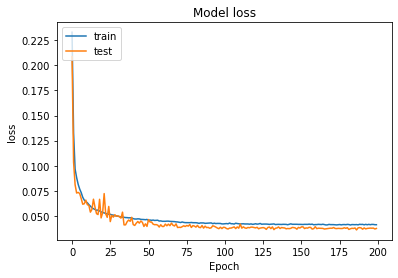

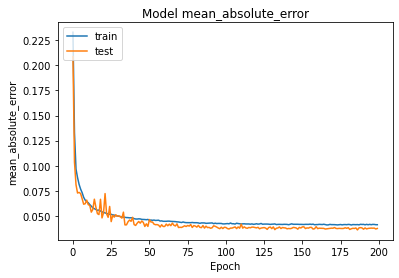

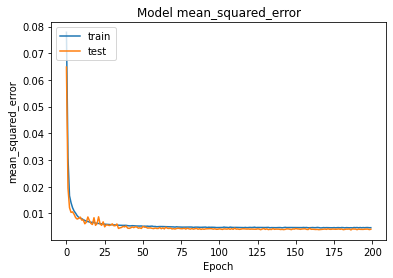

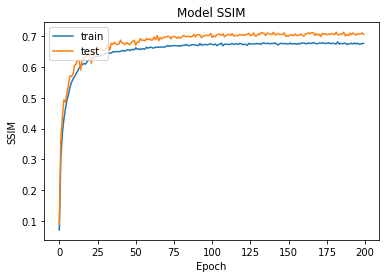

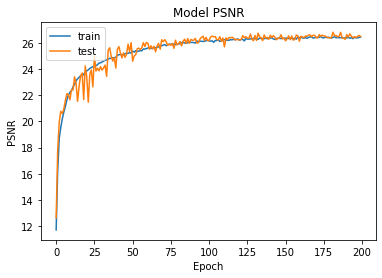

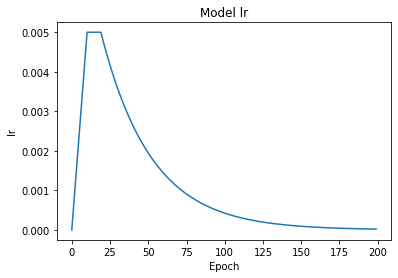

In [30]:
from utils.history_utils import show_history
offset = 0
show_history(history, offset)

In [ ]:
from utils.history_utils import show_history
offset = 0
show_history(history, offset)

In [ ]:
from utils.history_utils import show_history
offset = 0
show_history(history, offset)

In [ ]:
from utils.history_utils import show_history
offset = 0
show_history(history, offset)

In [ ]:
from utils.history_utils import show_history
offset = 0
show_history(history, offset)

In [ ]:
from utils.history_utils import show_history
offset = 0
show_history(history, offset)

In [ ]:
from utils.history_utils import show_history
offset = 0
show_history(history, offset)

In [ ]:
from utils.history_utils import show_history
offset = 0
show_history(history, offset)

In [ ]:
from utils.history_utils import show_history
offset = 0
show_history(history, offset)

In [ ]:
from utils.history_utils import show_history
offset = 0
show_history(history, offset)

In [ ]:
from utils.history_utils import show_history
offset = 0
show_history(history, offset)

### Save Model and History into Folder

In [28]:
description = '''
Description:
Fixed Zoom fraction augmentation error (too much zoom)
Simple UNet JPEG artifact removal (compression ratio tbd) - Q=20
Spatial Dropout p=0 and Prob Aug = 1/2 - removed stateless augmentations/rng wrap (see leg for stateless)
Without Pixel Shuffle (replaced by Conv Transpose)
Added residual blocks, more encoded convs after transmission, and norm back to math operations
Last layer also is a residual block now. Res block now only has 2 convs.

# Hyperparameters:
INPUT_SHAPE = [None, None, 3]
KERNEL_SIZE = [11, 11]#[7, 7]
DILATION_RATE = 2
BATCH_SIZE = 16#8
EPOCHS = 200
FILTERS = 16#4#8#32
# DROP_PROB = 0.05#0.075#0.05#0.075#0.25#0.1#0.05
KERNEL_REGULARIZER = tf.keras.regularizers.L2(0.00001)#None#tf.keras.regularizers.L2(0.0001)#None#tf.keras.regularizers.L2(0.0001)
KERNEL_INITIALIZER = "glorot_normal"#"orthogonal"#"glorot_normal"#"orthogonal"
DROP_PROB = None#0#0.15
INITIAL_LR = 0.005#0.001
LR_DECAY = 0.97#0.96#0.98#0.95#0.9#0.97#0.95#0.97#0.93
LR_DECAY_START = 10#25
ACTIVATION = 'elu'
AUGMENTATIONS = 20#10#1#10
VAL_AUGMENTATIONS = 10#1#10#5#10#100

Changed lr_schedule to :

def scheduler(epoch, lr):
    if epoch <= LR_DECAY_START:
        return (epoch/LR_DECAY_START)*INITIAL_LR + INITIAL_LR/10000
    elif epoch < 2*LR_DECAY_START:
        return lr
    elif epoch >= 2*LR_DECAY_START:
        return lr*LR_DECAY

with LR_DECAY_START=10, LR_DECAY=0.96, and INITIAL_LR=0.005'''
save_last_x_best_models = 2

if not os.path.exists('./trained_models'):
    os.mkdir('./trained_models')
output_dir = f'trained_models/saved_{model.name.lower()}_gpu{GPU}'

if not os.path.exists(output_dir):
    print(f'Creating New Directory at {output_dir}...')
    os.mkdir(output_dir)
else:
    print('Directory Already Exists...')
    output_dir += '_v1'
    while os.path.exists(output_dir):
        v_num = int(output_dir[-5:].partition('_v')[-1])
        output_dir = output_dir.partition(f'_v{v_num}')[0]
        v_num += 1
        output_dir += f'_v{v_num}'
    print(f'Creating New Directory at {output_dir}...')
    os.mkdir(output_dir)
final_val_loss = history.history['val_loss'][-1]
model.save(os.path.join(output_dir, f'saved_model-epoch_{EPOCHS}-val_loss_{final_val_loss:0.4f}.h5'))
best_model_dir = os.path.join(output_dir, 'best_models')
if not os.path.exists(best_model_dir):
    os.mkdir(best_model_dir)
print('Saving Best Model(s)...')
for i in range(save_last_x_best_models):
    file_list = [file for file in os.listdir(MODEL_DIR) if os.path.isfile(os.path.join(MODEL_DIR, file))]
    filename = sorted(file_list, key=lambda x: int(x.partition('h_')[2].partition('-')[0]))[-1]
    old_path = os.path.join(MODEL_DIR, filename)
    new_path = os.path.join(best_model_dir, filename)
    os.rename(old_path, new_path)
print('Saving History...')
save_history(history, output_dir)
print('Saving Description...')
with open(os.path.join(output_dir, "description.txt"), "a") as f:
    f.write(description)
print('Done!!!')

Directory Already Exists...
Creating New Directory at trained_models/saved_unet_gpu1_v1...
Saving Best Model(s)...
Saving History...
Saving Description...
Done!!!


### Load Model

In [ ]:
input_dir = 'saved_autoencoder_gpu0'

In [ ]:
#model = tf.keras.models.load_model('./saved_models/saved_model-epoch_08-val_loss_0.01138.h5', compile=False)

In [ ]:
input_dir = os.path.join('./trained_models', input_dir)
best_model_dir = os.path.join(input_dir, 'best_models')
file_list = [file for file in os.listdir(best_model_dir) if os.path.isfile(os.path.join(best_model_dir, file))]
filename = sorted(file_list, key = lambda x : int(x.partition('h_')[2].partition('-')[0]))[-1]
path = os.path.join(best_model_dir, filename)
print('Loading Model...')
print(f'Model Path: {path}')
model = tf.keras.models.load_model(path, compile=False)
print('Done!!!')

In [ ]:
model2.name

In [ ]:
model.summary()

In [ ]:
# _,train_img = next(iter(train_ds))
# figsize = (20,20)
# fig = plt.figure(figsize=figsize)
# ax = fig.add_axes([0, 0, 1, 1])
# ax.axis('off')
# ax.imshow(train_img[0,...,0], cmap = 'gray')
# plt.title('Train Image')
# plt.show()

In [33]:
in_img, gt = next(iter(train_ds))

In [34]:
in_img.shape

TensorShape([16, 256, 256, 3])

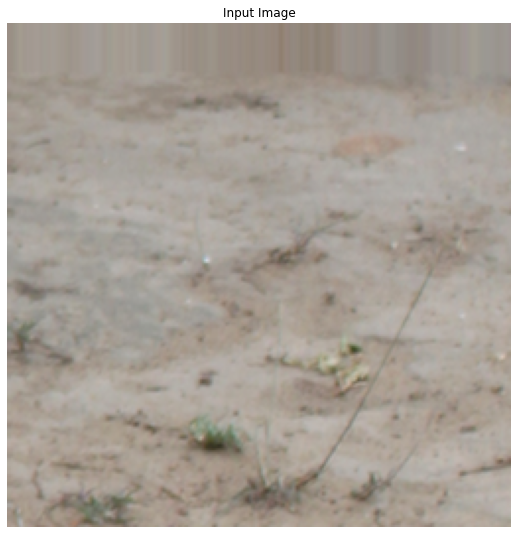

In [35]:
figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(in_img[6, ...])
plt.title('Input Image')
plt.show()

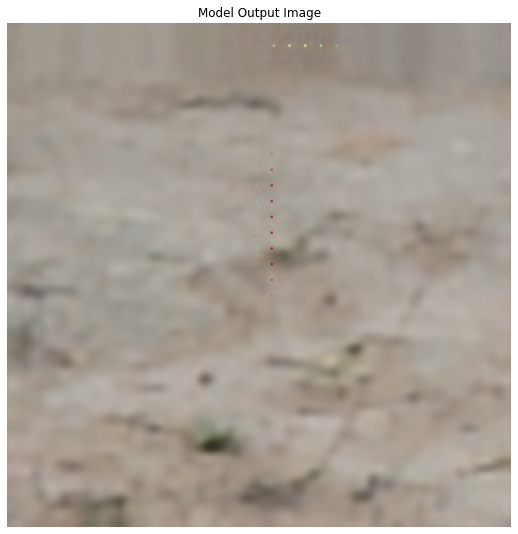

In [36]:
figsize = (7,7)
out_img = model(in_img, training=False)[6, ...]
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(out_img)
plt.title('Model Output Image')
plt.show()

In [ ]:
np.max(out_img)

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
!pip install graphviz

In [ ]:
!apt install graphviz